In [27]:
import numpy as np
import matplotlib.pyplot as plt

In [57]:
def eulers_method(initial_condtion:float, step_size:float, dx_dt:float):
    return initial_condtion + step_size * dx_dt

def heuns_method(initial_condtion:float, step_size:float, dx_dt:float):
    return initial_condtion + step_size * (dx_dt + eulers_method(initial_condtion, step_size, dx_dt) - initial_condtion) / 2

In [62]:
gamma = .25
betas = [0.03, 0.06, 0.1]
step_sizes = [0.01, 0.5, 2.0]

def numerical_sis_euler(gamma,beta,steps, step_size):
  S = 90
  N = 100
  I = N - S
  suseptible = [S]
  infected = [I]
  for _ in range(steps):
    temp_S = S
    temp_I = I
    temp_I = eulers_method(temp_I, step_size, beta * S * (N-S) - gamma * I)
    temp_S = eulers_method(temp_S, step_size, -beta * S * (N-S) + gamma * I)
    S = temp_S
    I = temp_I
    suseptible.append(S)
    infected.append(I)
  return suseptible, infected

def numerical_sis_heun(gamma,beta,steps, step_size):
  S = 90
  N = 100
  I = N - S
  suseptible = [S]
  infected = [I]
  for _ in range(steps):
    temp_S = S
    temp_I = I
    temp_I = heuns_method(temp_I, step_size, beta * S * (N-S) - gamma * I)
    temp_S = heuns_method(temp_S, step_size, -beta * S * (N-S) + gamma * I)
    S = temp_S
    I = temp_I
    suseptible.append(S)
    infected.append(I)
  return suseptible, infected



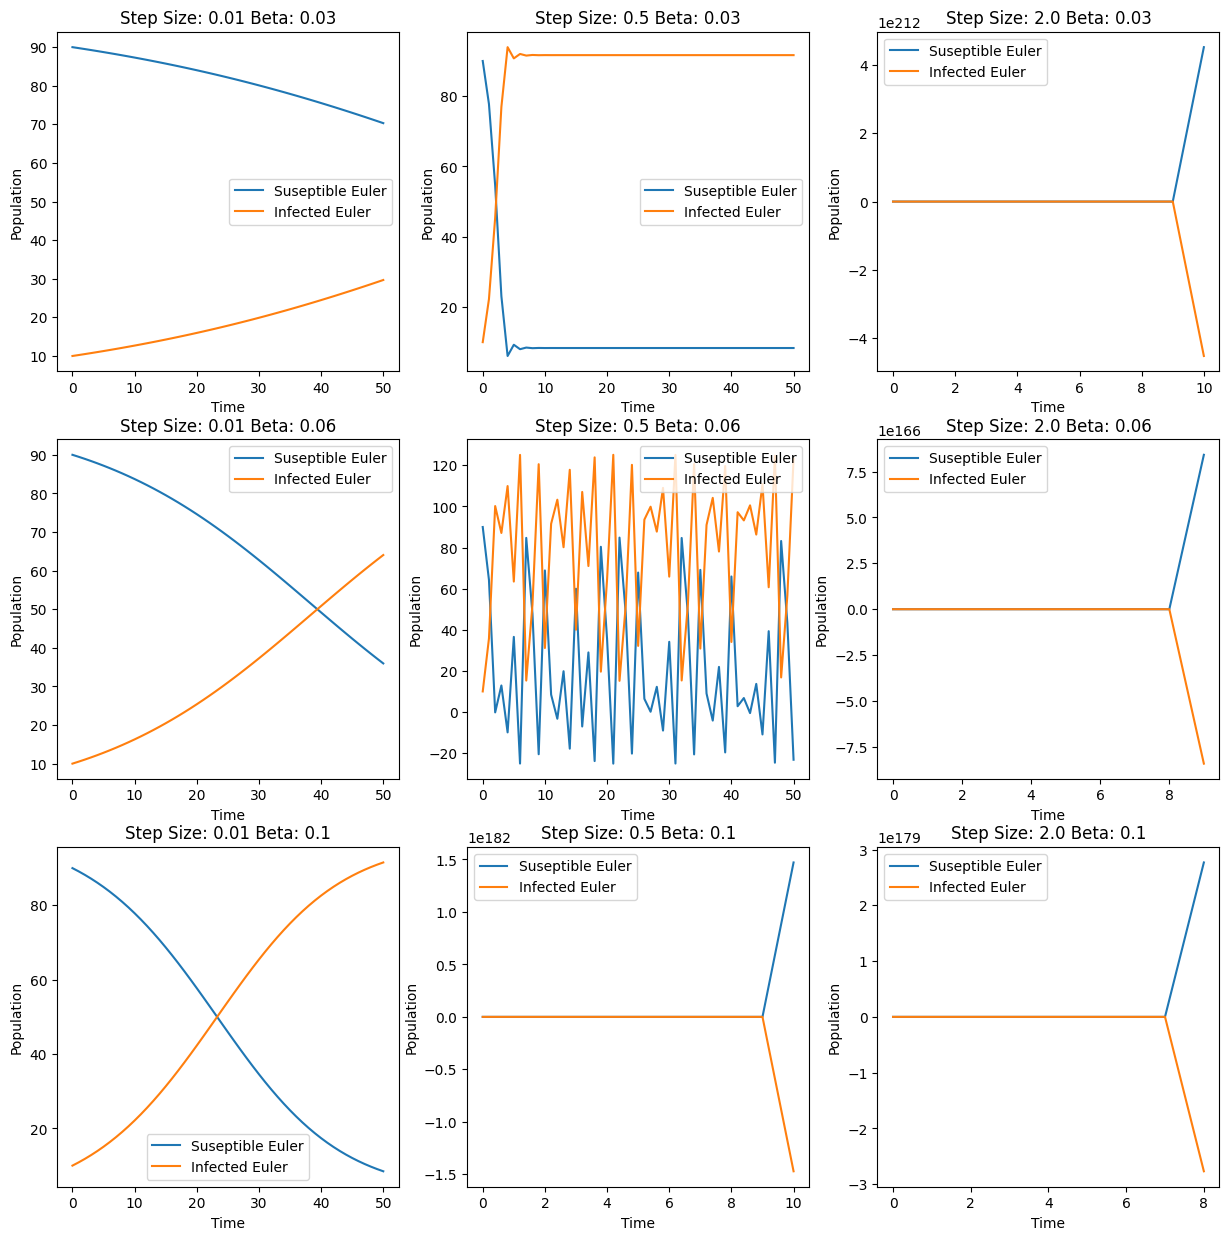

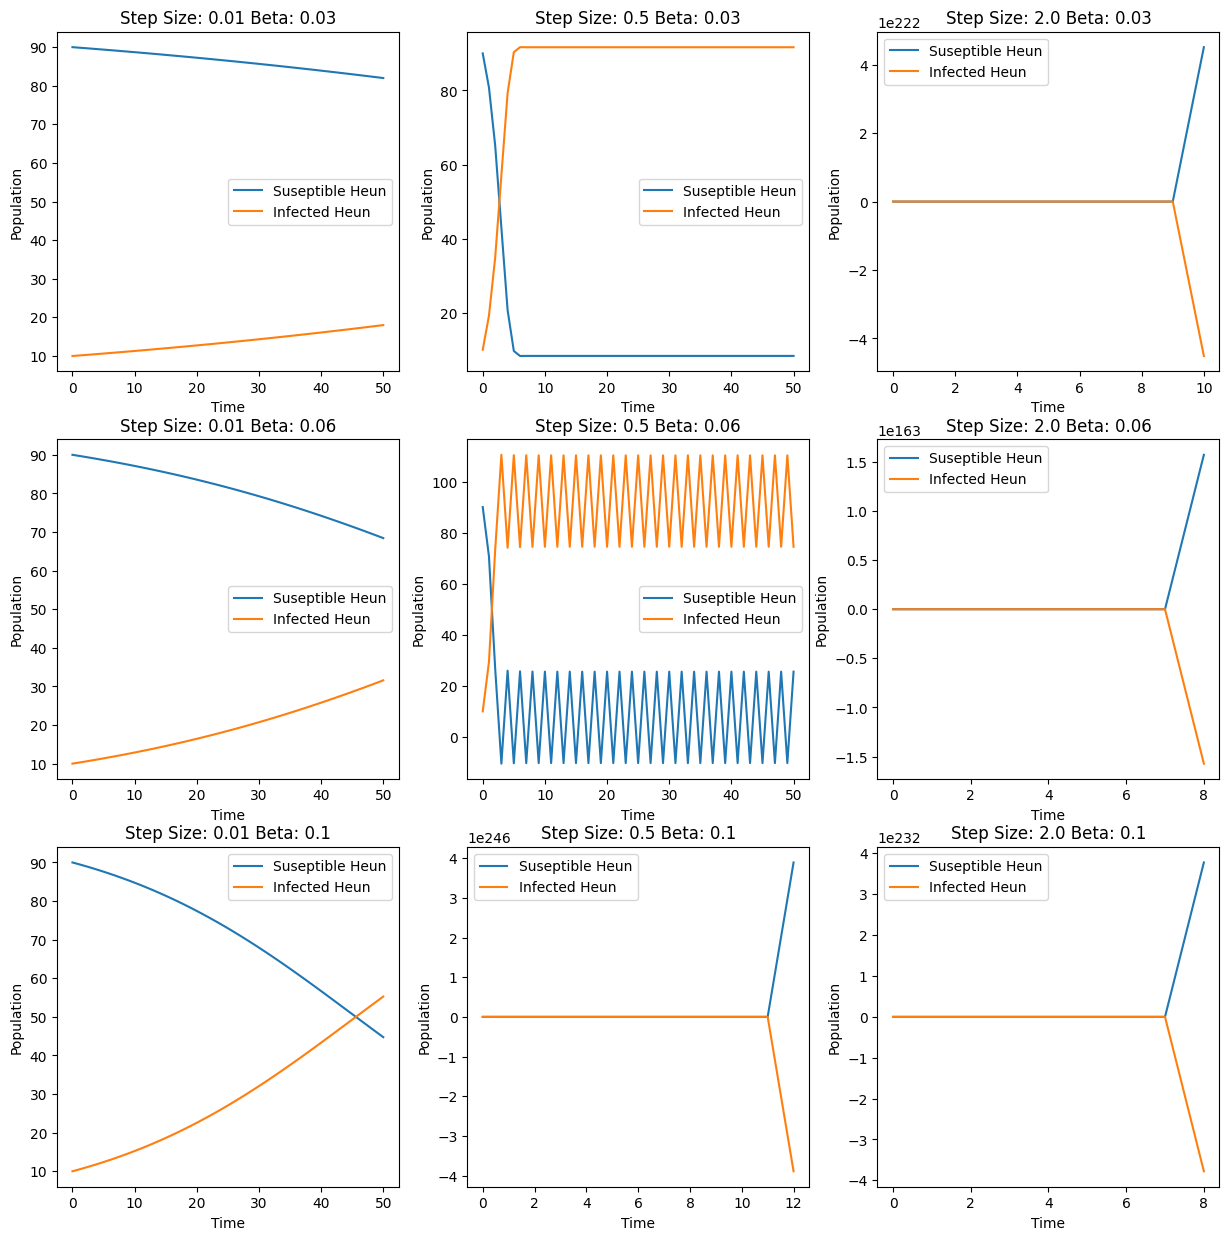

In [64]:
fig,ax = plt.subplots(3,3, figsize=(15,15))
for i, beta in enumerate(betas):
  for j, step_size in enumerate(step_sizes):
    ax[i,j].plot(numerical_sis_euler(gamma, beta, 50, step_size)[0], label="Suseptible Euler")
    ax[i,j].plot(numerical_sis_euler(gamma, beta, 50, step_size)[1], label="Infected Euler")
    ax[i,j].set_xlabel("Time")
    ax[i,j].set_ylabel("Population")
    ax[i,j].set_title(f"Step Size: {step_size} Beta: {beta}")
    ax[i,j].legend()
plt.show()

fig,ax = plt.subplots(3,3, figsize=(15,15))
for i, beta in enumerate(betas):
  for j, step_size in enumerate(step_sizes):
    ax[i,j].plot(numerical_sis_heun(gamma, beta, 50, step_size)[0], label="Suseptible Heun")
    ax[i,j].plot(numerical_sis_heun(gamma, beta, 50, step_size)[1], label="Infected Heun")
    ax[i,j].set_xlabel("Time")
    ax[i,j].set_ylabel("Population")
    ax[i,j].set_title(f"Step Size: {step_size} Beta: {beta}")
    ax[i,j].legend()
plt.show()

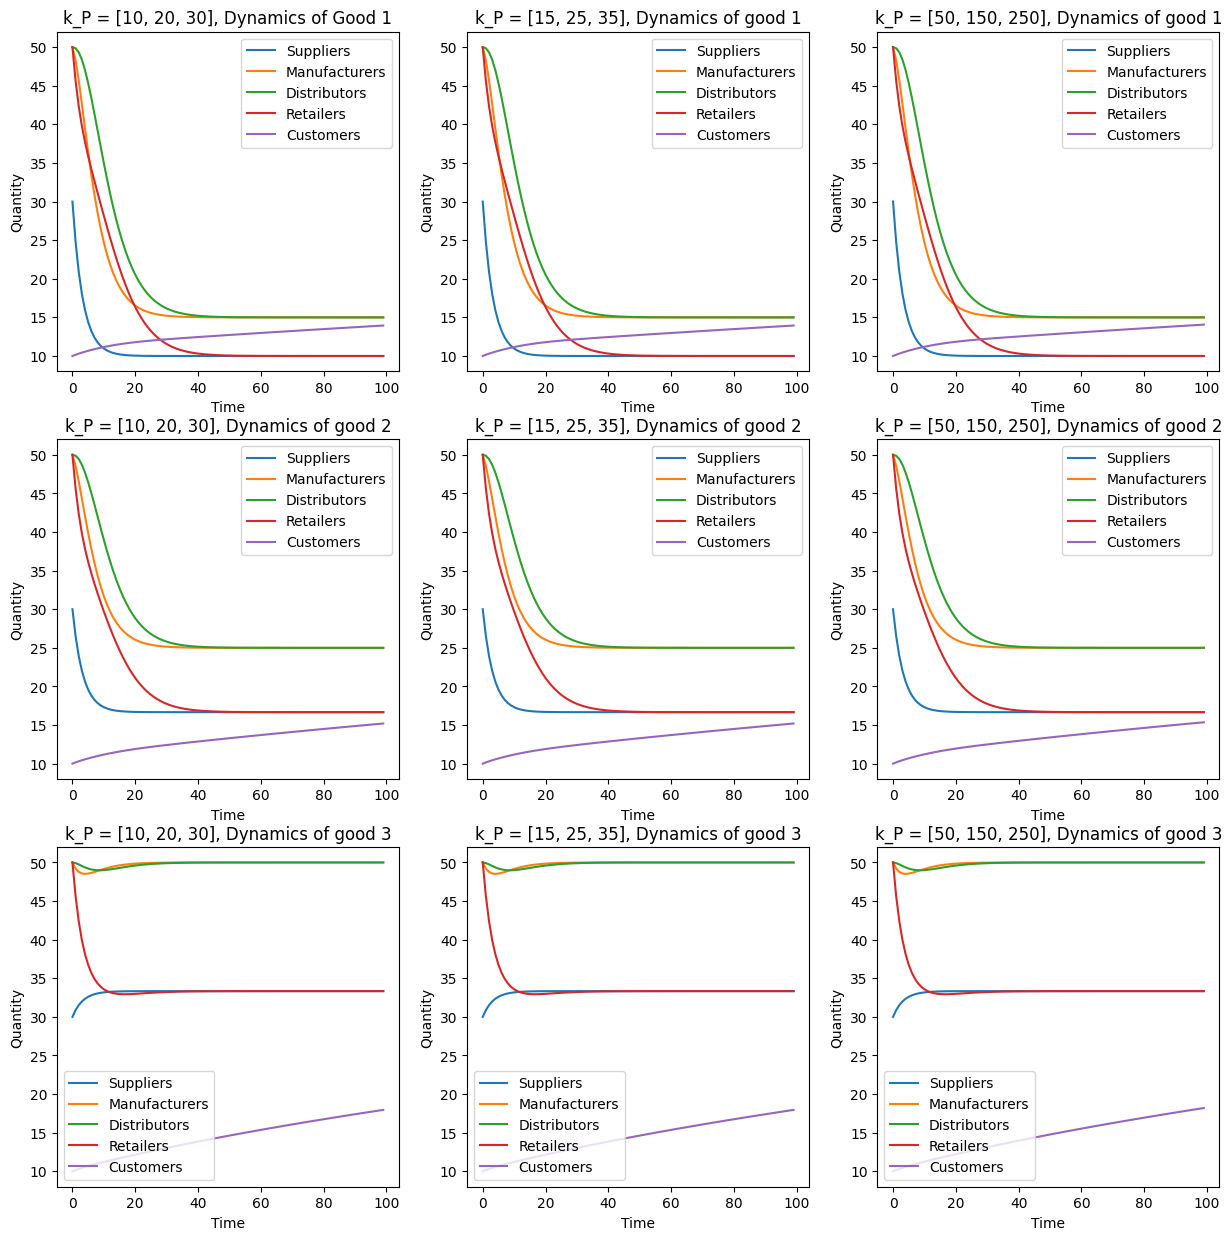

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the system of ODEs
def supply_chain(Y, t, K_p, k_SM, k_MD, k_DR, k_RC, A, P):
    n = len(k_SM)
    
    S = Y[:n]
    M = Y[n:2*n]
    D = Y[2*n:3*n]
    R = Y[3*n:4*n]
    C = Y[4*n:]
    
    dSdt = K_p - np.multiply(k_SM, S)
    dMdt = np.dot(A, np.multiply(k_SM, S)) - np.multiply(k_MD, M)
    dDdt = np.dot(A, np.multiply(k_MD, M)) - np.multiply(k_DR, D)
    dRdt = np.dot(A, np.multiply(k_DR, D)) - np.multiply(k_RC, R)
    dCdt = np.multiply(k_RC, R) * P / np.sum(Y[4*n:])
    
    return np.concatenate([dSdt, dMdt, dDdt, dRdt, dCdt])

# Define time span
t = np.linspace(0, 10, 100)

# Initial conditions (for a 3-goods example)
n = 3
S0 = np.array([30, 30, 30])
M0 = np.array([50, 50, 50])
D0 = np.array([50, 50, 50])
R0 = np.array([50, 50, 50])
C0 = np.array([10, 10, 10])
Y0 = np.concatenate([S0, M0, D0, R0, C0])

# Example parameters
K_p = np.array([2, 3, 2])
k_SM = np.array([3, 3, 3])
k_MD = np.array([2, 2, 2])
k_DR = np.array([2, 2, 2])
k_RC = np.array([3, 3, 3])
A = np.array([[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]])
P = np.array([0.33, 0.33, 0.34])

# Parameter sweep (example: varying k_SM)
k_P_values = [np.array([30, 30, 30]), np.array([50, 50, 50]), np.array([100, 100, 100])]
results = []

for k in range(len(k_P_values)):
    result = odeint(supply_chain, Y0, t, args=(k_P_values[k], k_SM, k_MD, k_DR, k_RC, A, P))
    results.append(result)

fig, ax = plt.subplots(3, 3, figsize=(15, 15))

ax[0,0].plot(results[0][:, 0::3][:, 0], label='Suppliers')
ax[0,0].plot(results[0][:, 0::3][:, 1], label='Manufacturers')
ax[0,0].plot(results[0][:, 0::3][:, 2], label='Distributors')
ax[0,0].plot(results[0][:, 0::3][:, 3], label='Retailers')
ax[0,0].plot(results[0][:, 0::3][:, 4], label='Customers')
ax[0,0].set_title('k_P = [10, 20, 30], Dynamics of Good 1') 
ax[0,0].set_xlabel('Time')
ax[0,0].set_ylabel('Quantity')
ax[0,0].legend()

ax[1,0].plot(results[1][:, 0::3][:, 0], label='Suppliers')
ax[1,0].plot(results[1][:, 0::3][:, 1], label='Manufacturers')
ax[1,0].plot(results[1][:, 0::3][:, 2], label='Distributors')
ax[1,0].plot(results[1][:, 0::3][:, 3], label='Retailers')
ax[1,0].plot(results[1][:, 0::3][:, 4], label='Customers')
ax[1,0].set_title('k_P = [10, 20, 30], Dynamics of good 2')
ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Quantity')
ax[1,0].legend()

ax[2,0].plot(results[2][:, 0::3][:, 0], label='Suppliers')
ax[2,0].plot(results[2][:, 0::3][:, 1], label='Manufacturers')
ax[2,0].plot(results[2][:, 0::3][:, 2], label='Distributors')
ax[2,0].plot(results[2][:, 0::3][:, 3], label='Retailers')
ax[2,0].plot(results[2][:, 0::3][:, 4], label='Customers')
ax[2,0].set_title('k_P = [10, 20, 30], Dynamics of good 3')
ax[2,0].set_xlabel('Time')
ax[2,0].set_ylabel('Quantity')
ax[2,0].legend()

ax[0,1].plot(results[0][:, 1::3][:, 0], label='Suppliers')
ax[0,1].plot(results[0][:, 1::3][:, 1], label='Manufacturers')
ax[0,1].plot(results[0][:, 1::3][:, 2], label='Distributors')
ax[0,1].plot(results[0][:, 1::3][:, 3], label='Retailers')
ax[0,1].plot(results[0][:, 1::3][:, 4], label='Customers')
ax[0,1].set_title('k_P = [15, 25, 35], Dynamics of good 1')
ax[0,1].set_xlabel('Time')
ax[0,1].set_ylabel('Quantity')
ax[0,1].legend()

ax[1,1].plot(results[1][:, 1::3][:, 0], label='Suppliers')
ax[1,1].plot(results[1][:, 1::3][:, 1], label='Manufacturers')
ax[1,1].plot(results[1][:, 1::3][:, 2], label='Distributors')
ax[1,1].plot(results[1][:, 1::3][:, 3], label='Retailers')
ax[1,1].plot(results[1][:, 1::3][:, 4], label='Customers')
ax[1,1].set_title('k_P = [15, 25, 35], Dynamics of good 2')
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('Quantity')
ax[1,1].legend()

ax[2,1].plot(results[2][:, 1::3][:, 0], label='Suppliers')
ax[2,1].plot(results[2][:, 1::3][:, 1], label='Manufacturers')
ax[2,1].plot(results[2][:, 1::3][:, 2], label='Distributors')
ax[2,1].plot(results[2][:, 1::3][:, 3], label='Retailers')
ax[2,1].plot(results[2][:, 1::3][:, 4], label='Customers')
ax[2,1].set_title('k_P = [15, 25, 35], Dynamics of good 3')
ax[2,1].set_xlabel('Time')
ax[2,1].set_ylabel('Quantity')
ax[2,1].legend()

ax[0,2].plot(results[0][:, 2::3][:, 0], label='Suppliers')
ax[0,2].plot(results[0][:, 2::3][:, 1], label='Manufacturers')
ax[0,2].plot(results[0][:, 2::3][:, 2], label='Distributors')
ax[0,2].plot(results[0][:, 2::3][:, 3], label='Retailers')
ax[0,2].plot(results[0][:, 2::3][:, 4], label='Customers')
ax[0,2].set_title('k_P = [50, 150, 250], Dynamics of good 1')
ax[0,2].set_xlabel('Time')
ax[0,2].set_ylabel('Quantity')
ax[0,2].legend()

ax[1,2].plot(results[1][:, 2::3][:, 0], label='Suppliers')
ax[1,2].plot(results[1][:, 2::3][:, 1], label='Manufacturers')
ax[1,2].plot(results[1][:, 2::3][:, 2], label='Distributors')
ax[1,2].plot(results[1][:, 2::3][:, 3], label='Retailers')
ax[1,2].plot(results[1][:, 2::3][:, 4], label='Customers')
ax[1,2].set_title('k_P = [50, 150, 250], Dynamics of good 2')
ax[1,2].set_xlabel('Time')
ax[1,2].set_ylabel('Quantity')
ax[1,2].legend()

ax[2,2].plot(results[2][:, 2::3][:, 0], label='Suppliers')
ax[2,2].plot(results[2][:, 2::3][:, 1], label='Manufacturers')
ax[2,2].plot(results[2][:, 2::3][:, 2], label='Distributors')
ax[2,2].plot(results[2][:, 2::3][:, 3], label='Retailers')
ax[2,2].plot(results[2][:, 2::3][:, 4], label='Customers')
ax[2,2].set_title('k_P = [50, 150, 250], Dynamics of good 3')
ax[2,2].set_xlabel('Time')
ax[2,2].set_ylabel('Quantity')
ax[2,2].legend()

plt.show()